<a href="https://colab.research.google.com/github/jmolins89/final-project/blob/master/New_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

# Loading data ...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
categories=['NORMAL','PNEUMONIA']
IMG_SIZE=200

def create_training_data(datadir,IMG_SIZE):
    '''
    '''
    lst=[]
    categories = ['NORMAL', 'PNEUMONIA']
    for category in categories:
        path = os.path.join(datadir, category)  # path to normal or pneumonia
        class_num=categories.index(category)    # Set category by index in categories: 0 -> Normal, 1 -> Pneumonia
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   # read the original image
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resizes the original image to a IMG_SIZE
                lst.append([new_array,class_num])     # Appends to the list a tuple with array resized and each label
            except Exception as e:
                pass
    return lst

training_data = create_training_data('/content/drive/My Drive/chest_xray/train',200)
test_data = create_training_data('/content/drive/My Drive/chest_xray/test',200)
validation_data = create_training_data('/content/drive/My Drive/chest_xray/val',200)

In [0]:
random.shuffle(training_data)
random.shuffle(test_data)
random.shuffle(validation_data)

In [0]:
def createxy(data):
    X,y=[],[]
    for features,label in data:
        X.append(features/255)
        y.append(label)
    return X,y


In [0]:
X_train=np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test=np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_val=np.array(X_val).reshape(-1,IMG_SIZE,IMG_SIZE,1)


# Exporting arrays with images and labels

In [0]:
import pickle

pickle_out = open('X_train.pickle','wb')
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open('y_train.pickle','wb')
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open('X_test.pickle','wb')
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open('y_test.pickle','wb')
pickle.dump(y_test, pickle_out)
pickle_out.close()

pickle_out = open('X_val.pickle','wb')
pickle.dump(X_val, pickle_out)
pickle_out.close()

pickle_out = open('y_val.pickle','wb')
pickle.dump(y_val, pickle_out)
pickle_out.close()

In [0]:
import pickle
pickle_in1=open('/content/drive/My Drive/X_train.pickle','rb')
pickle_in2=open('/content/drive/My Drive/y_train.pickle','rb')
pickle_in3=open('/content/drive/My Drive/X_test.pickle','rb')
pickle_in4=open('/content/drive/My Drive/y_test.pickle','rb')
pickle_in5=open('/content/drive/My Drive/X_val.pickle','rb')
pickle_in6=open('/content/drive/My Drive/y_val.pickle','rb')

X_train,y_train=pickle.load(pickle_in1),pickle.load(pickle_in2)
X_test,y_test=pickle.load(pickle_in3),pickle.load(pickle_in4)
X_val,y_val=pickle.load(pickle_in5),pickle.load(pickle_in6)

In [6]:
len(X_train)

5216

In [4]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.callbacks import TensorBoard
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import ReLU
import imageio
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


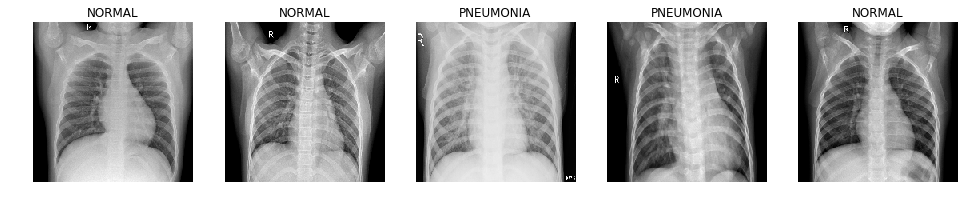

In [5]:
dic={0:'NORMAL',1:'PNEUMONIA'}
plt.figure(figsize=(20,12))
for index,img in enumerate(X_train[:5]):  
    plt.subplot(1,6,index+1)
    plt.imshow(img.reshape(200,200), cmap='gray')
    plt.axis('off')
    plt.title(dic.get(y_train[index]))
plt.show()

In the previous images **we can't distinguish the case with pneumonia against the case without pneumonia** if we are not a doctor.

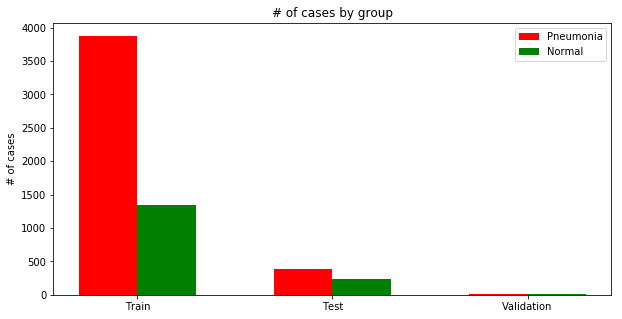

In [6]:
N = 3
normal=(y_train.count(0),y_test.count(0),y_val.count(0))
pneumonia=(y_train.count(1),y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()



In the previous graph we can observe that **the data is unbalanced**, because we have more Pneumonia cases than Normal.

We have to **rebalance** the data to train better a neural network.

We are going to use the SMOTE method to generate random images between normal ones.



In [7]:
np.bincount(y_train)

array([1341, 3875])

In [8]:
print('{} normal cases to create for train data'.format(np.bincount(y_train)[1]-np.bincount(y_train)[0]))
print('{} normal cases to create for test data'.format(np.bincount(y_test)[1]-np.bincount(y_test)[0]))
print('{} normal cases to create for validation data'.format(np.bincount(y_val)[1]-np.bincount(y_val)[0]))

2534 normal cases to create for train data
156 normal cases to create for test data
0 normal cases to create for validation data


In [0]:
sm = SMOTE(random_state=42)

In [0]:
#from imblearn.over_sampling import SMOTE

#def makeOverSamplesSMOTE(X,y):
#    sm = SMOTE()
#    X, y = sm.fit_sample(X, y)
#    return X,y
#X_train_resampled, y_train_resampled = makeOverSamplesSMOTE(X_train, y_train)

## **Creando generador imágenes**

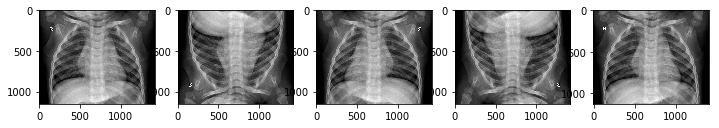

In [9]:
from google.colab.patches import cv2_imshow
imageSource = '/content/drive/My Drive/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = cv2.imread(imageSource)
 
# copy image to display all 4 variations
horizontal_img = img.copy()
vertical_img = img.copy()
both_img = img.copy()
 
# flip img horizontally, vertically,
# and both axes with flip()
horizontal_img = cv2.flip( img, 0 )
vertical_img = cv2.flip( img, 1 )
both_img = cv2.flip( img, -1 )
 
# display the images on screen with imshow()
plt.figure(figsize=(12,4))
plt.subplot(1,5,1)
plt.imshow(img )
plt.subplot(1,5,2)
plt.imshow(horizontal_img )
plt.subplot(1,5,3)
plt.imshow(vertical_img )
plt.subplot(1,5,4)
plt.imshow( both_img )
plt.subplot(1,5,5)
plt.imshow(img[10:-10,10:-10] )
 
# wait time in milliseconds
# this is required to show the image
# 0 = wait indefinitely
cv2.waitKey(0)
 
# close the windows
cv2.destroyAllWindows()

In [0]:
normalindex=[i for i,e in enumerate(y_train) if e==0 ]
#X_train[normalindex]

In [0]:
#
new_images=[]
new_labels=[]
def verticalflip(list_images,list_labels):
  for imagen in X_train[normalindex]:
    img = imagen
    vertical_img = img.copy()
    vertical_img = cv2.flip( img, 1 )
    list_images.append(vertical_img)
    list_labels.append(0)
    cv2.waitKey(0)
    return list_images, list_labels

In [0]:
new_images=[]
new_labels=[]
for imagen in X_train[normalindex]:
  new_img = imagen[10:-10,10:-10].copy()
  new_img = cv2.resize(new_img,(200,200))
  new_images.append(new_img)
  new_labels.append(0)
  cv2.waitKey(0)

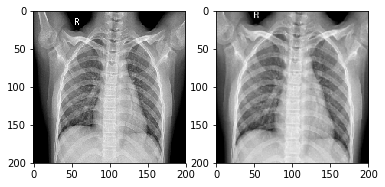

In [39]:
plt.subplot(1,2,1)
plt.imshow(X_train[normalindex][1].reshape(200,200), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(new_images[1].reshape(200,200),cmap='gray')
plt.show()

In [17]:
a=X_train
b=np.array(new_images).reshape(-1,200,200,1)
c=y_train
d=np.array(new_labels)

print(len(a))
print(len(b))
X_train_more_data = np.concatenate((a,b),axis=0)
y_train_more_data = np.concatenate((c,d),axis=0)
print(len(X_train_more_data))
print(len(y_train_more_data))
np.bincount(y_train_more_data)

5216
1341
6557
6557


array([2682, 3875])

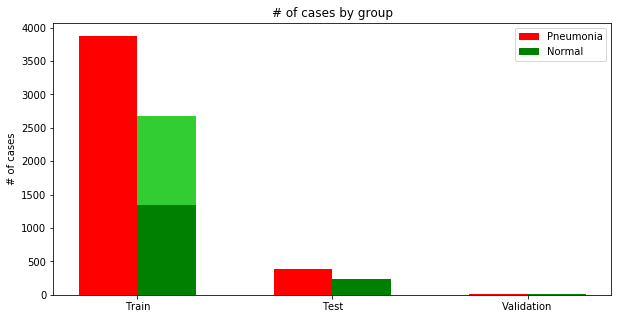

In [24]:
N = 3
normal0=(y_train.count(0),y_test.count(0),y_val.count(0))
normal=(np.bincount(y_train_more_data)[0],y_test.count(0),y_val.count(0))
pneumonia=(np.bincount(y_train_more_data)[1],y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal, width, color='limegreen')
p2 = plt.bar(ind+0.15, normal0, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()

# Convolutional Neural Network

In [0]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)
y_val_binary = to_categorical(y_val)
y_train_more_data_binary = to_categorical(y_train_more_data)

In [25]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200,1), activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))
model.summary()

W0804 15:29:45.152299 140269721765760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 15:29:45.168239 140269721765760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 15:29:45.171689 140269721765760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 15:29:45.198263 140269721765760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0804 15:29:45.200608 140269721765760 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 64)        0         
__________

In [26]:
model.compile(
    loss='categorical_crossentropy',  # we train 2-way classification
    optimizer=keras.optimizers.Adadelta(),  # for SGD
    metrics=['accuracy'],  # report accuracy during training
    #shuffle=True,
    #verbose=1
)
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
modeltrain = model.fit(x=X_train_more_data,y=y_train_more_data_binary, epochs=30,#,callbacks=[tensorboard])#,
                   validation_split=0.1, batch_size=128)

W0804 15:29:59.063784 140269721765760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0804 15:29:59.072618 140269721765760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0804 15:29:59.166454 140269721765760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5901 samples, validate on 656 samples
Epoch 1/30
5901/5901 [==============================] - 25s 4ms/step - loss: 0.6645 - acc: 0.6472 - val_loss: 0.9723 - val_acc: 0.0000e+00
Epoch 2/30
5901/5901 [==============================] - 17s 3ms/step - loss: 0.6189 - acc: 0.6909 - val_loss: 0.6926 - val_acc: 0.5701
Epoch 3/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.3876 - acc: 0.8388 - val_loss: 1.4911 - val_acc: 0.1235
Epoch 4/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.2614 - acc: 0.8990 - val_loss: 0.2850 - val_acc: 0.8902
Epoch 5/30
5901/5901 [==============================] - 19s 3ms/step - loss: 0.2283 - acc: 0.9109 - val_loss: 0.3644 - val_acc: 0.8613
Epoch 6/30
5901/5901 [==============================] - 19s 3ms/step - loss: 0.1926 - acc: 0.9204 - val_loss: 0.1652 - val_acc: 0.9863
Epoch 7/30
5901/5901 [==============================] - 19s 3ms/step - loss: 0.1815 - acc: 0.9300 - val_loss: 0.5187 - val_acc: 0.7744
Epoc

In [45]:
len(X_train_more_data)

6557

In [19]:
modeltrain.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

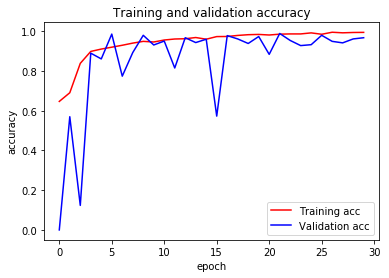

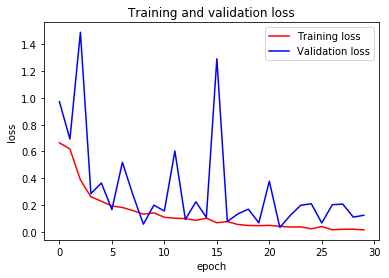

In [27]:
#Graphing our training and validation
acc = modeltrain.history['acc']
val_acc = modeltrain.history['val_acc']
loss = modeltrain.history['loss']
val_loss = modeltrain.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [28]:
val_loss,val_acc = model.evaluate(X_test,y_test_binary)
print(val_loss,val_acc)

624/624 [==============================] - 1s 2ms/step
1.6090836158165565 0.8092948717948718


In [0]:
predictions=model.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_binary.argmax(axis=1), predictions.argmax(axis=1))


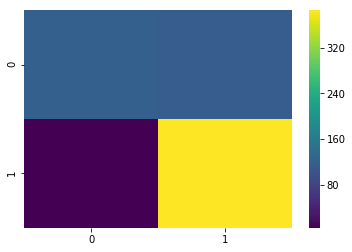

In [31]:
import seaborn as sns
sns.heatmap(matrix, cmap='viridis');

In [32]:
matrix

array([[119, 115],
       [  4, 386]])

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)#, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Normalized confusion matrix


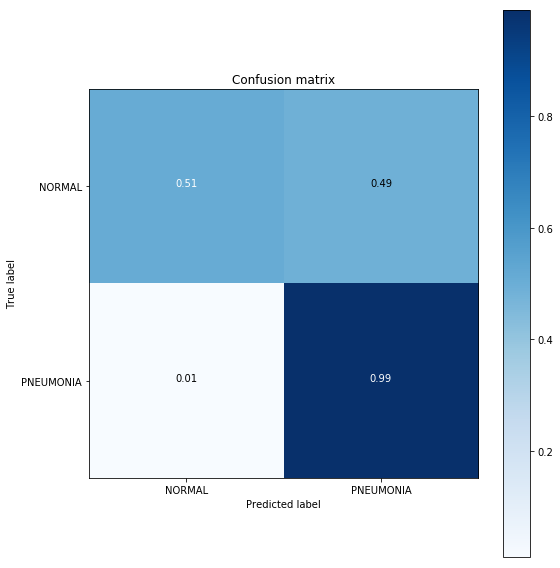

In [34]:
preds = np.argmax(model.predict(X_test), axis = 1)
cm = confusion_matrix([np.argmax(i) for i in y_test_binary],preds)
keys = ['NORMAL','PNEUMONIA']
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

# Generando más imágenes para balancear la muestra

In [0]:
new_images2=[]
new_labels2=[]
for imagen in X_train[normalindex]:
  new_img = imagen[20:-20,20:-20].copy()
  new_img = cv2.resize(new_img,(200,200))
  new_images2.append(new_img)
  new_labels2.append(0)
  cv2.waitKey(0)

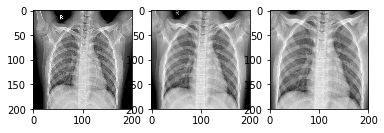

In [40]:
plt.subplot(1,3,1)
plt.imshow(X_train[normalindex][1].reshape(200,200), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(new_images[1].reshape(200,200),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(new_images2[1].reshape(200,200),cmap='gray')
plt.show()